In [1]:
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings("ignore")#, category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

In [2]:
import os
import csv
import nltk
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows = 999
import numpy as np
import glob
import re
import string
import seaborn as sbn
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import preprocessor as p
from ekphrasis.classes.segmenter import Segmenter
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from datetime import datetime
import json
from pprintpp import pprint
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.stem.porter import *
%matplotlib inline

sbn.set(style='ticks', font_scale=1.5)

In [4]:
dfsel_ppp = pd.read_csv('../../chapter2/results/20210426_prospect_allTweets_table.csv', index_col=0)
#dfsel_ppp = pd.read_csv('../../Tweet_TM_result/STTM_model/20210428_flushing_allTweets_table.csv', index_col=0)
dfsel_ppp['Date'] = dfsel_ppp['Date'].map(lambda x: pd.Timestamp(x))
dfsel_ppp['Date'] = dfsel_ppp['Date'].dt.tz_localize('utc').dt.tz_convert('US/Eastern')

In [5]:
# Select only model probability >0.3
dfsel_hp = dfsel_ppp[dfsel_ppp['topic_prob']>0.3]
dfsel_hp.shape

(4786, 39)

In [6]:
dfcat = pd.read_excel('../../chapter2/results/prospect_pre_a005_b003_topics_update.0724.xlsx', index_col=0)
#dfcat = pd.read_excel('../../Tweet_TM_result/STTM_model/result_topics/flushing_a005_b003_topics.xlsx', index_col=0)
dfcat.head()

,count,Main theme,Subtheme,Keywords,example
topc #,,,,,
218,60,Culture,Photography,"see, video, lake, morning, thank, look, know, ...",I took my Canon C200 out to Prospect Park last...
262,37,Culture,Monument,"monument, Shirley Chisholm, artist, designer, ...",NaN
42,82,Events,Celebrate Brooklyn,"concert, tonight, see, Celebrate Brooklyn, wai...",This is the exact same crowd in size and demog...
23,50,Events,Celebrate Brooklyn,"festival, celebrate Brooklyn, Bric Celebrate B...",NaN
167,44,Events,General event,"artist, event, weekend, ticket, week, film, pr...",NaN


In [7]:
dfall = pd.merge(left=dfsel_hp, right=dfcat, left_on='topic_number', right_on='topc #', how='left')

In [8]:
# Remove pattern function
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [9]:
# Remove emoticons from column 'Author'
dfall['Author'] = dfall['Author'].str.replace("[^\w()'+]", " ")

# Remove Twitter Handles
dfall['Tidy_text'] = np.vectorize(remove_pattern)(dfall['fulltext'], "@[\w]*")

# Remove links
dfall['Tidy_text'] = dfall['Tidy_text'].str.replace("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ")

# Remove special characters, numbers, punctuations (except exclamation mark)
dfall['Tidy_text'] = dfall['Tidy_text'].str.replace("[^a-zA-Z#!]", " ")

# Remove short words
dfall['Tidy_text'] = dfall['Tidy_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))



In [10]:
dfall['Tidy_text'][10:15]

10               There nowhere poop Prospect Park Story
11    Snow Brooklyn! #prospectpark #brooklyn #snow B...
12    strange population hipsters popped Prospect Pa...
13                   Prospect Park snow horses sledding
14    Doing more neighbrhd mrning done lifetime elde...
Name: Tidy_text, dtype: object

In [11]:
# Tokenize Data
tokenize_tweets = dfall['Tidy_text'].apply(lambda x: x.split()) 

# Stemming Data
stemmer = PorterStemmer()
tokenize_tweets = tokenize_tweets.apply(lambda x: [stemmer.stem(i) for i in x])

for i in range(len(tokenize_tweets)):
    tokenize_tweets[i] = ' '.join(tokenize_tweets[i])

dfall['Tidy_text'] = tokenize_tweets

In [12]:
tokenize_tweets

0       downtown brooklyn storefront go home from pros...
1       that awesom thanks! also wife show prospect pa...
2       earn everi last those badg take hill corner pr...
3       screen women direct film regular sinc #womensh...
4       much snow york where stick around prospect par...
                              ...                        
4781    uncl nick bare skate help simon learn push ska...
4782    quit chilli morn brooklyn today repres borough...
4783    such pleasur hang with everyon today inaugur l...
4784    were crack dawn greet these mile done thi morn...
4785    fact about absolut ador busi dahmthemodel they...
Name: Tidy_text, Length: 4786, dtype: object

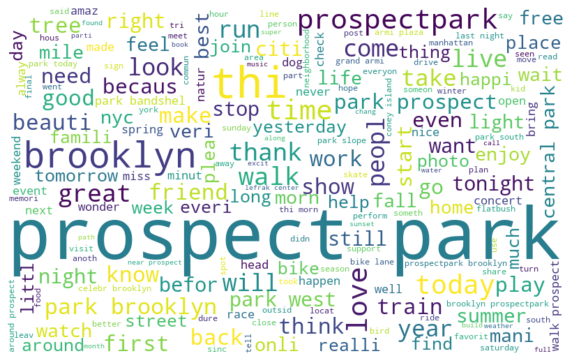

In [13]:
# WordCloud
all_words = ' '.join([text for text in dfall['Tidy_text']])

wordcloud = WordCloud(width=800, height=500, random_state=21, background_color='white',  max_font_size=110).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [14]:
# Calculate Polarity

analyser = SentimentIntensityAnalyzer()

scores = []
for sentence in dfall['Tidy_text']:
    score = analyser.polarity_scores(sentence)
    scores.append(score)

scores = pd.DataFrame(scores)

dfall['Compound'] = scores['compound']
dfall['Negative'] = scores['neg']
dfall['Neutral'] = scores['neu']
dfall['Positive'] = scores['pos']

In [15]:
# Calculate Mentions
def word_extract(x):
    words = []
    for i in x:
        ht = re.findall(r"(\w+)", i)
        words.append(ht)
    return words

# Extract words
words = word_extract(dfall['Tidy_text'])

# words
# Unnesting list
words = sum(words, [])

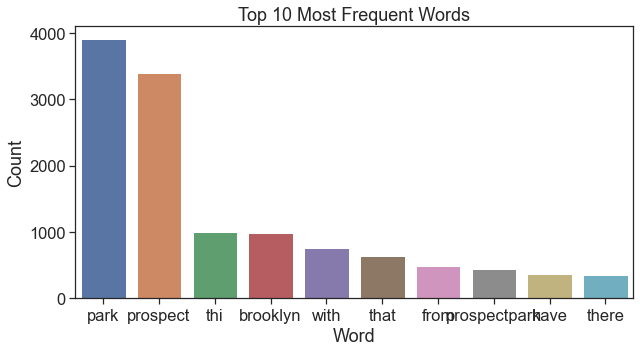

In [16]:
# Frequency Distribution

a = nltk.FreqDist(words)

b = pd.DataFrame({'Word': list(a.keys()), 'Count': list(a.values())})
length = len(b)

# Top 10 Most Frequent Words
b = b.nlargest(columns="Count", n = 10)
plt.figure(figsize=(10,5))
axis = sbn.barplot(data=b, x='Word', y='Count')
axis.set(ylabel='Count')
plt.title('Top 10 Most Frequent Words')
plt.show()

In [17]:
# Set type of polarity
polarity = []

for i in range(len(dfall)):
    if (dfall['Compound'][i] < 0):
        polarity.append("Negative")
    elif (dfall['Compound'][i] > 0):
        polarity.append("Positive")
    else:
        polarity.append("Neutral")
    
polarity = pd.DataFrame(polarity)
dfall['Polarity'] = polarity

In [18]:
dfall['time_EST'] = pd.to_datetime(dfall['Date'],  utc=True)
dfall['only_date'] = dfall['time_EST'].apply(lambda x: x.date())


In [19]:
# Remove Main theme == 'Other'
dfall = dfall[-(dfall['Main theme'].isin(['Other']))]
dfall.shape

(4283, 50)

In [20]:
dfall.columns

Index(['index', 'Url', 'Date', 'Gender', 'Account Type', 'Twitter Verified',
       'Author', 'userID', 'Hashtags', 'Longitude', 'Latitude', 'City',
       'Location Name', 'Sentiment', 'Twitter Retweet of', 'fulltext', 'id',
       'hashtag_seg', 'inKeywords', 'inGeo', 'inLong', 'original_fulltext',
       'num_RedunTweet_perUser', 'MoreThan2RedunTweets_perUser',
       'numTweet_perUser', 'rank5remove', 'rank1remove', 'num_vocab',
       'atleast_3_vocab', 'cleantext', 'num_RedunCleanTweet_perUser',
       'time_EST', 'only_date', 'ngrams', 'clean_text_trigrams',
       'clean_text_trigrams_cutlowfreq', 'clean_text_trigrams_cutlowfreq_ori',
       'topic_number', 'topic_prob', 'count', 'Main theme', 'Subtheme',
       'Keywords', 'example', 'Tidy_text', 'Compound', 'Negative', 'Neutral',
       'Positive', 'Polarity'],
      dtype='object')

In [21]:
piv = dfall.pivot_table(index=['Main theme'], columns='Polarity', values='id', aggfunc='count')
piv = (piv.T/piv.T.sum(axis=0)).T
piv

Polarity,Negative,Neutral,Positive
Main theme,,,
Culture,0.053,0.168,0.779
Events,0.073,0.152,0.776
General leisure activity,0.067,0.098,0.835
Nature,0.074,0.122,0.804
Park features,0.233,0.175,0.592
Physical activity,0.073,0.131,0.796
Social relations,0.111,0.074,0.815
Transportation,0.151,0.113,0.736
Urban space,0.031,0.090,0.879


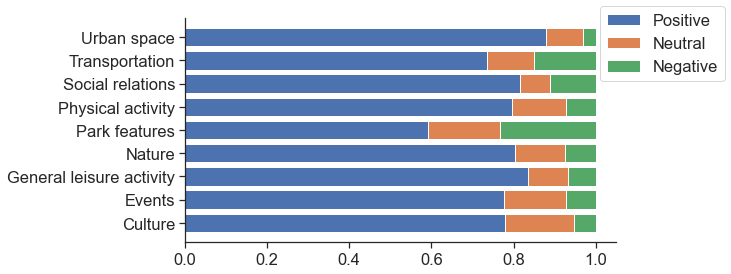

In [22]:
fig, ax = plt.subplots(1,1, figsize=(9,4))
ax.barh(piv.index, piv['Positive'],label='Positive')
ax.barh(piv.index, piv['Neutral'], label='Neutral', left=piv['Positive'])
ax.barh(piv.index, piv['Negative'], label='Negative', left=piv['Positive']+ piv['Neutral'])
fig.legend(bbox_to_anchor=(1.15, 1.0))
sbn.despine()
fig.tight_layout()
#fig.savefig('../../Tweet_TM_result/STTM_model/Figures/ProspectPark/20210616_Prospect_SentimentByTheme.png', dpi=300, bbox_inches = 'tight')
fig.savefig('../../chapter2/results/20210724_Prospect_SentimentByTheme.png', dpi=300, bbox_inches = 'tight')

<AxesSubplot:title={'center':'Polarity per Day'}, xlabel='only_date'>

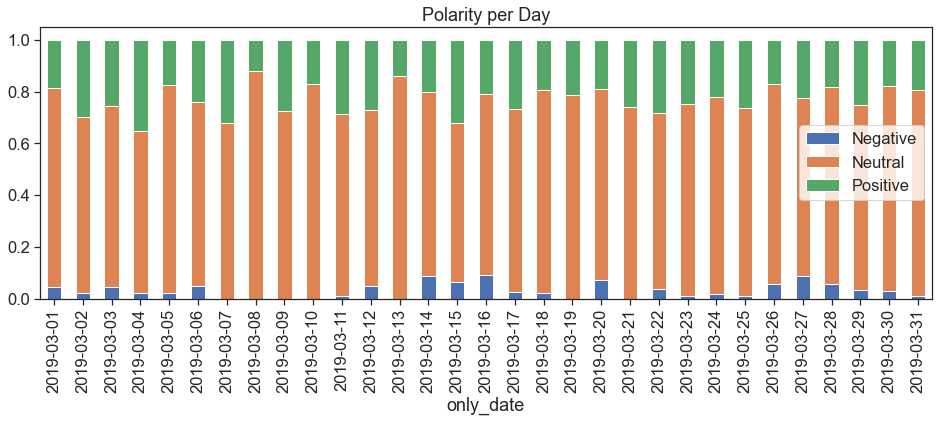

In [25]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
dftmp = dfall.reset_index(drop=True)
#dftmp = dftmp.pivot_table(index=['year', 'month', 'date'], values='id', aggfunc='count')
idx = pd.date_range("2019-03-01", periods=31)
x = dfall[dfall['Date'] < '2019-04-01'][['only_date', 'Negative', 'Neutral', 'Positive']]
y = x.set_index('only_date')
z = y.groupby('only_date').mean()

z.plot.bar(stacked=True, title='Polarity per Day', figsize=(16,5), ax=ax)

In [26]:
dfall['hashtag_seg_str'] = dfall['hashtag_seg'].str.replace('[\[\]\']', '').str.replace('\s', '').str.replace('#', '').str.replace(',', ' ')

In [27]:
dfall.to_csv('../../Tweet_TM_result/STTM_model/Figures/ProspectPark/20210616_Prospect_allTweets_table_topicResult_and_Sentiment.csv')
#dfall.to_csv('../../Tweet_TM_result/STTM_model/Figures/ProspectPark/20210501_Prospect_sentiment_results.csv')

In [28]:
dfall['clean_text_trigrams_cutlowfreq']

0                                     ['downtown', 'saw']
1                        ['thank', 'meet', 'wife', 'guy']
3       ['screen', 'woman', 'direct', 'film', 'check',...
4       ['ask', 'snow', 'stick', 'run', 'winter', 'won...
5                    ['tree', 'grow', 'prospect_heights']
                              ...                        
4780                 ['fan', 'waiting', 'finish', 'line']
4781    ['uncle', 'nick', 'ice', 'skate', 'learn', 'pu...
4782    ['morning', 'represent', 'borough', 'birth', '...
4783    ['pleasure', 'hang', 'leather', 'dyke', 'ice',...
4784    ['crack', 'dawn', 'greet', 'mile', 'morning', ...
Name: clean_text_trigrams_cutlowfreq, Length: 4283, dtype: object

In [29]:
dfall['hashtag_seg']

0                                                    ['']
1                                                    ['']
3                                 ['#womenshistorymonth']
4                                      ['#climatechange']
5                            ['#brooklynny', '#brooklyn']
                              ...                        
4780                                      ['#algordon4m']
4781                                                 ['']
4782                                                 ['']
4783                                                 ['']
4784    ['#workinprogress', '#thestruggleisreal', '#20...
Name: hashtag_seg, Length: 4283, dtype: object

In [30]:
dfall['hashtag_seg'].str.replace('[\[\]\']', '').str.replace('\s', '').str.replace('#', '').str.replace(',', ' ')

0                                                     
1                                                     
3                                   womenshistorymonth
4                                        climatechange
5                                  brooklynny brooklyn
                             ...                      
4780                                        algordon4m
4781                                                  
4782                                                  
4783                                                  
4784    workinprogress thestruggleisreal 2020istheyear
Name: hashtag_seg, Length: 4283, dtype: object

In [31]:
dfall[dfall['fulltext'].str.contains('hellopanda', flags=re.IGNORECASE)]

,index,Url,Date,Gender,Account Type,Twitter Verified,Author,userID,Hashtags,Longitude,...,Subtheme,Keywords,example,Tidy_text,Compound,Negative,Neutral,Positive,Polarity,hashtag_seg_str
